# Methodology  🎯
* This notebook will demonstrate **Bird Call Identification** with `TensorFlow`. 
* This notebook will also show how to use `tf.data` for **Audio Processing** task.
* This notebook also demonstrates how to extract **Spectrogram** features from **Raw Audio** using TensorFlow. Specifically how to read `.ogg` file in TensorFlow.
* This notebook will also show how to set up **Augmentation Pipeline** for audio data. It will also implement some cool augmentations such as **CutMix** and **MixUp** for **Audio** data.
* This notebook also shows how we can use **Filter Stride Reduction (FSR)** to improve model's performence.
* This notebook is compatible with both **GPU**, **TPU**, and newly launched **TPU-VM** Device is automatically selected so you won't have to do anything to allocate device.

# Notebooks 📓

* EffNet + FSR + CutMixUp
    * Train: [BirdCLEF23: EffNet + FSR + CutMixUp [Train]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit)
    * Infer: [BirdCLEF23: EffNet + FSR + CutMixUp [Infer]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-infer/edit)


# Update 🔄
* `v10`:
    * Filter data for cross-validation
    * Upsample data for minority class
* `v13`:
    * Train record duration is reduced to $10$ sec to reduce memory overhead.
    * Spectrogram shape is reduced to $128 \times 256$

# Install Libraries 🛠

## For `TPU VM v3-8`

Usually these libraries come pre-installed for other accelerators but fo tpu-vm we need to install them manually. If you want to use rather remote-TPU or GPU or CPU, then comment out the following cell.


## EfficientNet with Filter Stride Reduction (FSR)
By default efficient don't come with this feature thus code need to be modified. In following repo I have modified the code to reduce the stride $2 \times$ in stem block. You can check the [source code](https://github.com/awsaf49/efficientnet-spec) for more details.

In [1]:
# efficientnet with filter stride reduction (FSR)
! pip install -qU git+https://github.com/awsaf49/efficientnet-spec

# Import Libraries 📚

In [2]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)
# Enable xla for speed up
tf.config.optimizer.set_jit(True)

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

# Import KaggleDatasets for accessing Kaggle datasets
from kaggle_datasets import KaggleDatasets

2023-04-07 02:53:19.006985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 02:53:19.096968: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 02:53:19.705207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nv

## Library Version

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('librosa:', librosa.__version__)
print('tf:', tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('tfio:', tfio.__version__)

np: 1.21.6
pd: 1.3.5
sklearn: 1.0.2
librosa: 0.10.0.post2
tf: 2.11.0
tfp: 0.19.0
tfa: 0.19.0
tfio: 0.29.0


# Configuration ⚙️

In [4]:
class CFG:
    # Debugging
    debug = False
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    _wandb_kernel = 'awsaf49'
    
    # Experiment name and comment
    exp_name = 'baseline-v2'
    comment = 'EfficientNetB0|FSR|t=10s|128x384|up_thr=50|cv_filter'
    
    # Notebook link
    notebook_link = 'https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit'
    
    # Verbosity level
    verbose = 0
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB0'
    fsr = True # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Data augmentation parameters
    augment=True
    
    # Spec augment
    spec_augment_prob = 0.80
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 0.5
    
    mask_prob = 0.65
    freq_mask = 20
    time_mask = 30


    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# WandB 🪄
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To track model's training I'll be using **Weights & Biases** tool. Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Specifically for this notebook, we can do error analysis to check in which audio files models are struggling as we can also log **audio** file in WandB.

In [6]:
# Import wandb library for logging and tracking experiments
import wandb

# Try to get the API key from Kaggle secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    # Login to wandb with the API key
    wandb.login(key=api_key)
    # Set anonymous mode to None
    anonymous = None
except:
    # If Kaggle secrets are not available, set anonymous mode to 'must'
    anonymous = 'must'
    # Login to wandb anonymously and relogin if needed
    wandb.login(anonymous=anonymous, relogin=True)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Set Up Device  📱
Following codes automatically detects hardware(tpu or tpu-vm or gpu). 

In [7]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [8]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

2023-04-07 02:53:26.021788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 02:53:26.047773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 02:53:26.048003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 02:53:26.050432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 02:53:26.050653: I tensorflow/compile

> Running on GPU | Num of GPUs:  1


# Dataset Path 📁
`TPU v3-8` aka `Remote-TPU` requires GCS path for training. Thankfully kaggle provides us GCS path for each dataset. Following codes automatically uses GCS path if remote TPU is used as device.

In [9]:
BASE_PATH = '/kaggle/input/birdclef-2023'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])
else:
    GCS_PATH = BASE_PATH

# Meta Data 📖
* **train_audio/** - folder contains training data of short recordings of individual bird calls uploaded by users of xenocanto.org. These files have been downsampled to  $32,000$ Hz where applicable to match the test set audio and converted to the `.ogg` format. The training data should have nearly all relevant files; It can be expected there will be no benefit to looking for more on xenocanto.org.
* **test_soundscapes/** - directory contains $~200$ recordings to be used for scoring when a notebook is submitted. Without submission only $1$ recording is accessible.  All recordings are $10$ minutes long and in `.ogg` audio format.
* **train_metadata.csv** - file contains a wide range of metadata the training data. The most directly relevant fields are:
    * `primary_label` - a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.
    * `seconday_label` - if any other bird call exists on the recording. This feature is carefully used in top solution before.
    * `latitude & longitude`: coordinates for where the recording was taken. Some bird species may have local call 'dialects,' so you may want to seek geographic diversity in your training data.
    * `author` - The user who provided the recording.
    * `filename`: the name of the associated audio file.
* **sample_submission.csv** - is the valid sample submission.
    * `row_id`: A slug of [soundscape_id]_[end_time] for the prediction.
    * `[bird_id]`: There are $264$ bird ID columns. The probability of the presence of each bird for each row needs to be predicted.
* **eBird_Taxonomy_v2021.csv** - data on the relationships between different species.

In [10]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = GCS_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

primary_label secondary_labels      type  latitude  longitude  \
0       abethr1               []  ['song']    4.3906    38.2788   
1       abethr1               []  ['call']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5   

                                 url              filename  \
0  https://www.xeno-canto.org/128013  abethr1/XC128013.ogg   
1  https://www.xeno-canto.org/363501  abethr1/XC363501.ogg   

                                            filepath  target  
0  /kaggle/input/birdclef-2023/train_audio/abethr...       0  
1  /kaggle/input/birdclef-2023/train_audio/abethr...       0

In [11]:
tf.io.gfile.exists(df.filepath.iloc[0])

True

# EDA 🎨

## Utility

In [12]:
import cv2

def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def show_image(filename):
    img = cv2.imread(f'/kaggle/input/birdclef23-image-dataset/{filename}.jpg')
    img = img[...,::-1] # bgr => rgb
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('OFF')
    plt.show()
    return img

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    # print("# Image:")
    # show_image(row.common_name)
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Top 3 Categories

In [13]:
stat = df.primary_label.value_counts().index.tolist()
class_names = stat[:3] + stat[-3:] # popular + not popular

In [14]:
print(class_names)

['barswa', 'wlwwar', 'thrnig1', 'whhsaw1', 'afpkin1', 'crefra2']


## Popular Categories

### Barn Swallow

In [15]:
class_name = class_names[0]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: barswa
# Num Samples: 500
# Audio:


# Visualization:


### Willow Warbler

In [16]:
class_name = class_names[1]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: wlwwar
# Num Samples: 500
# Audio:


# Visualization:


### Thursh Nightingale

# Category: thrnig1
# Num Samples: 500
# Audio:


# Visualization:


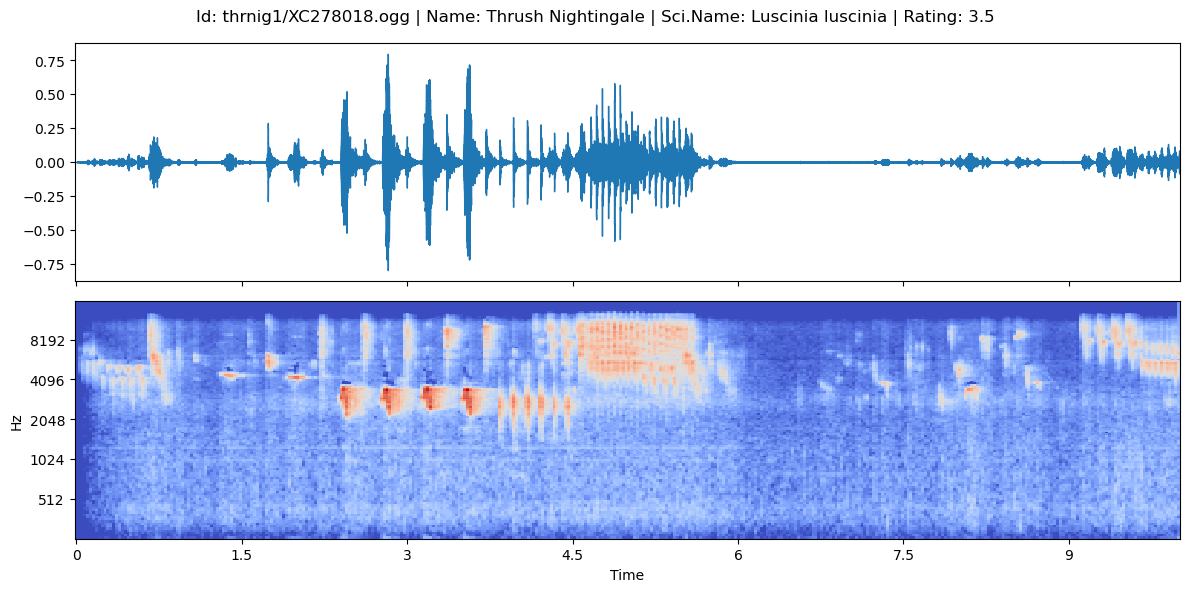

In [17]:
class_name = class_names[2]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

## UpPopular Categories

### White-headed Sawwing

# Category: whhsaw1
# Num Samples: 1
# Audio:


# Visualization:


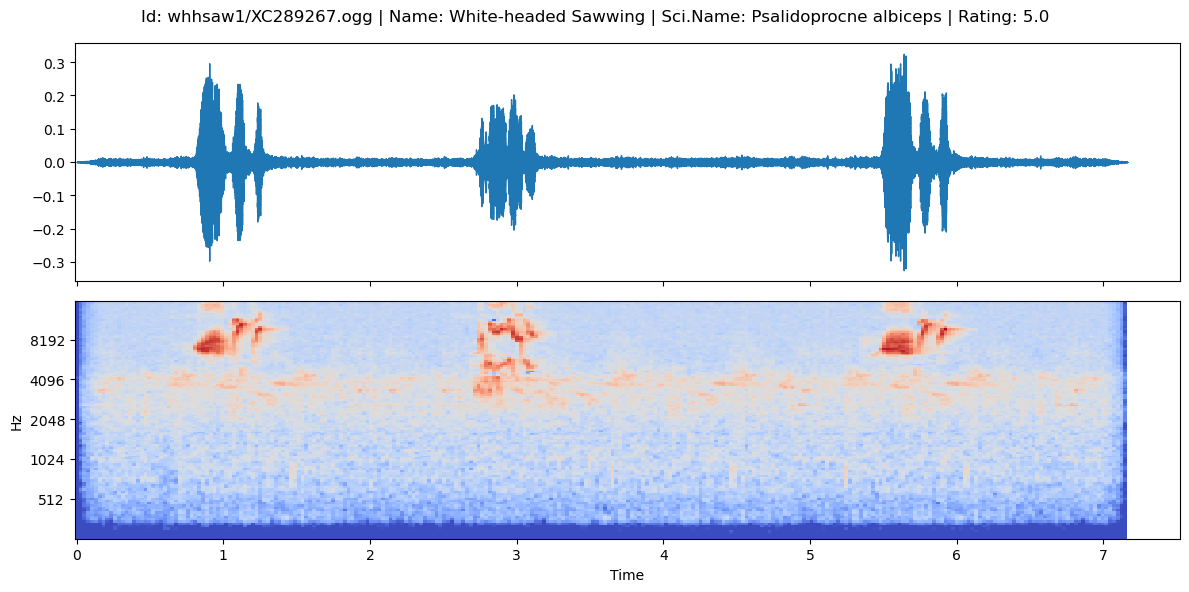

In [18]:
class_name = class_names[-3]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

### African Pygmy Kingfisher

# Category: afpkin1
# Num Samples: 1
# Audio:


# Visualization:


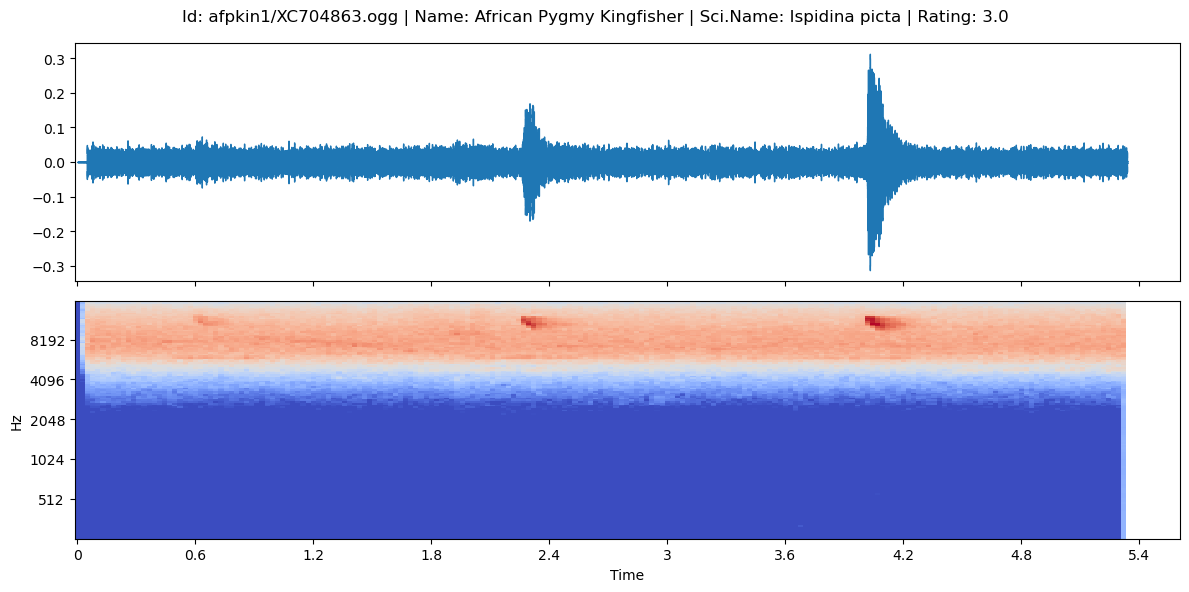

In [19]:
class_name = class_names[-2]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

### Crested Francolin


# Category: crefra2
# Num Samples: 1
# Audio:


# Visualization:


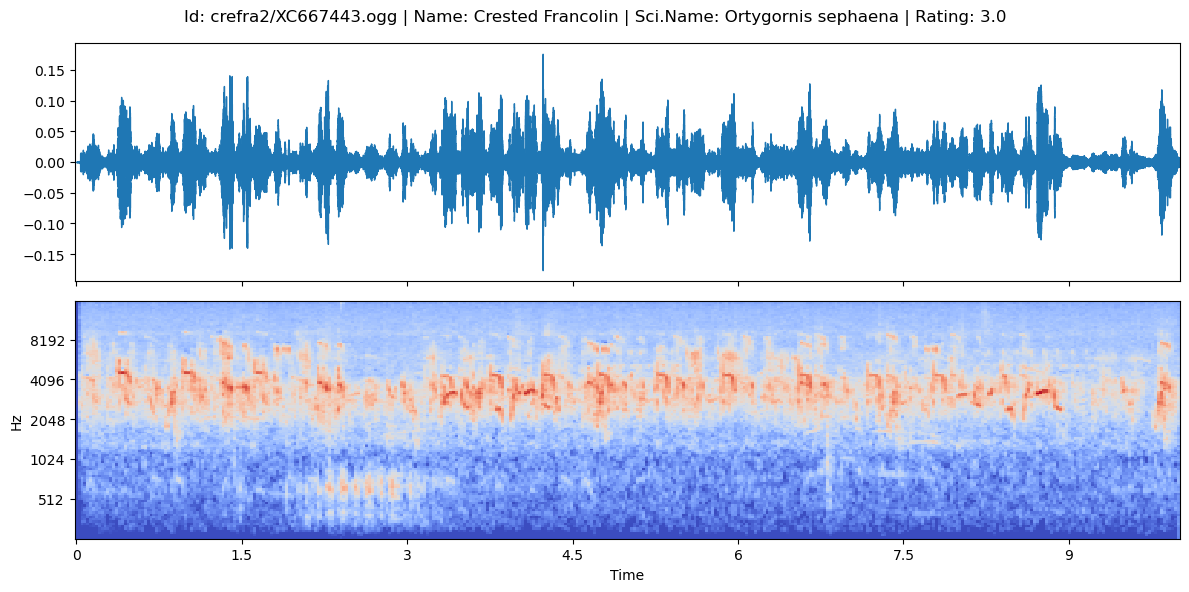

In [20]:
class_name = class_names[-1]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Data Split 🔪
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [21]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [22]:
df.groupby(['fold','primary_label']).size()

fold  primary_label
0     abethr1           3
      abhori1          26
      abythr1           5
      afbfly1           4
      afdfly1           6
                       ..
4     yertin1          27
      yesbar1           6
      yespet1           3
      yetgre1           5
      yewgre1          22
Length: 1271, dtype: int64

# Filter & Upsample Data ⬆️

* **Filter**: As there is even only one sample for some classes we need to make sure they are in the train data using filtering. We can do this by always keeping them in the train data and do cross-validtion on the rest of the data.

* **Upsample**: Even in the filtered data there are some minority classes with very few samples. To amend the class imbalance we can try upsampling those classes. Following function will simply upsample the train data for minory class which has very few samples. This can potentially mitigate the classic "Long Tail" problem.


In [23]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

## Filter Data

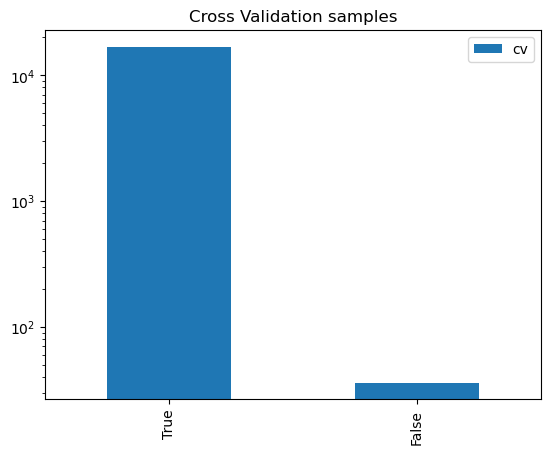

In [24]:
# Filter data
f_df = filter_data(df, thr=5)
f_df.cv.value_counts().plot.bar(legend=True)
plt.yscale("log")
plt.title("Cross Validation samples")
plt.show()

## Upsample Data

Before Upsample Size: 16941
After Upsample Size: 22208


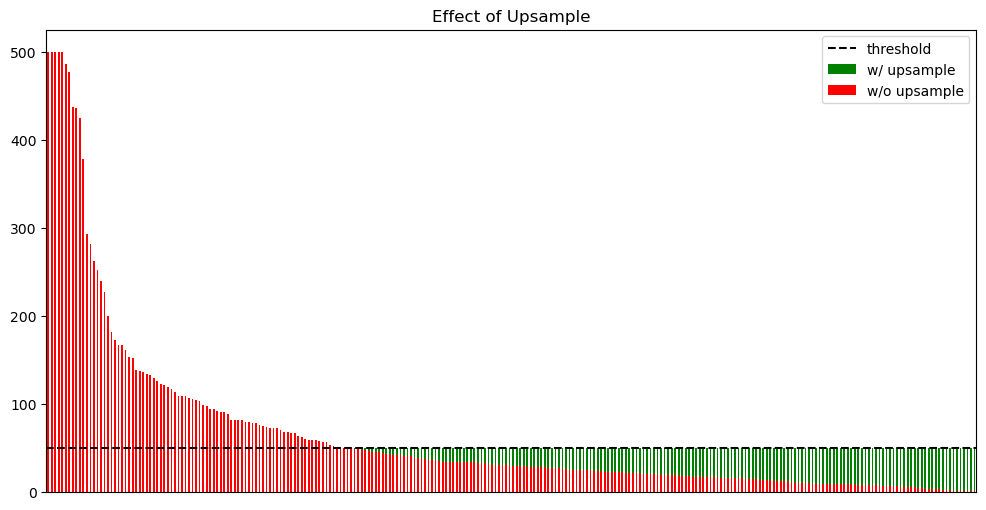

In [25]:
# Upsample data
up_df = upsample_data(df, thr=50)
print(f'Before Upsample Size: {len(df)}')
print(f'After Upsample Size: {len(up_df)}')

# Show effect of upsample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
up_df.primary_label.value_counts()[:].plot.bar(ax=ax, color='green', label='w/ upsample')
df.primary_label.value_counts()[:].plot.bar(ax=ax, color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=50, color='k', linestyle='--', label='threshold')
plt.legend()
plt.title("Effect of Upsample")
plt.show()

# Data Augmentation 🌈
> **Caution:** Even though we are training audio as an image (spectrogram), we can't use typical computer-vision augmentations such as HorizontalFlip, Rotation, Shear, etc as it may contaminate the information contained within the image (spectrogram). For example, if we rotate a spectrogram then it doesn't make sense anymore as we can't relate this rotated spectrogram to the actual audio. 

## Used Augmentations
Two types of Augmentations are used here, 
1. **AudioAug**: Augmentations that will be applied directly to **audio** data. Example: Gaussian Noise, Random CropPad.
2. **SpecAug**: Augmentations that will be applied to **spectrogram** data. Example: TimeFreqMask, CutMixUp.

Here are some example images before and after these augmentations,
## AudioAug:

* Random Noise
<img src="https://i.ibb.co/nQYZwry/aug.png" alt="aug" border="0">

* Random TimeShift
<img src="https://i.ibb.co/xC2zHsr/aug-timeshift.png" alt="aug-timeshift" border="0">

* Random CropOrPad
<img src="https://i.ibb.co/DzkNKPz/aug-crop-or-pad.png" alt="aug-crop-or-pad" border="0">

## SpecAug:

* Random TimeMask
<img src="https://i.ibb.co/T0jdwrT/spec-time-mask.png" alt="spec-time-mask" border="0">

* Random FreqMask
<img src="https://i.ibb.co/16qk6tn/spec-freq-mask.png" alt="spec-freq-mask" border="0">

* CutMix
<img src="https://i.ibb.co/LrsZsKs/spec-cutmix.png" alt="spec-cutmix" border="0">

* MixUp
<img src="https://i.ibb.co/DRY0nC2/spec-mixup.png" alt="spec-mixup" border="0">

## Utility

In [26]:
# Generates random integer
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

## AudioAug
Applies augmentation directly to audio

In [27]:
# Import required packages
import tensorflow as tf

# Define a function to crop or pad audio data to a target length
@tf.function
def CropOrPad(audio, target_len, pad_mode='constant'):
    # Get the length of the input audio
    audio_len = tf.shape(audio)[0]
    # If the length of the input audio is smaller than the target length, randomly pad the audio
    if audio_len < target_len:
        # Calculate the offset between the input audio and the target length
        diff_len = (target_len - audio_len)
        # Select a random location for padding
        pad1 = random_int([], minval=0, maxval=diff_len)
        # Calculate the second padding value
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        # Apply padding to the audio data
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode)
    # If the length of the input audio is larger than the target length, crop the audio
    elif audio_len > target_len:
        # Calculate the difference in length between the input audio and the target length
        diff_len = (audio_len - target_len)
        # Select a random location for cropping
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32)
        # Crop the audio data
        audio = audio[idx: (idx + target_len)]
    # Reshape the audio data to the target length
    audio = tf.reshape(audio, [target_len])
    # Return the cropped or padded audio data
    return audio


# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
@tf.function
def TimeShift(audio, prob=0.5):
    # Randomly apply time shift with probability `prob`
    if random_float() < prob:
        # Calculate random shift value
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        # Randomly set the shift to be negative with 50% probability
        if random_float() < 0.5:
            shift = -shift
        # Roll the audio signal by the shift value
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
@tf.function
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    # Select a random value of standard deviation for Gaussian noise within the given range
    std = random_float([], std[0], std[1])
    # Randomly apply Gaussian noise with probability `prob`
    if random_float() < prob:
        # Add random Gaussian noise to the audio signal
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    # Apply time shift and Gaussian noise to the audio signal
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

# Standardize the audio
@tf.function
def Normalize(data, min_max=True):
    # Compute the mean and standard deviation of the data
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    # Standardize the data
    data = tf.math.divide_no_nan(data - MEAN, STD)
    # Normalize to [0, 1]
    if min_max:
        MIN = tf.math.reduce_min(data)
        MAX = tf.math.reduce_max(data)
        data = tf.math.divide_no_nan(data - MIN, MAX - MIN)
    return data

## SpecAug
Applies augmentation to spectrogram instead of audio

In [28]:
# Convert spectrogram (H,W) to image (H,W,3)
@tf.function
def Spec2Img(spec, num_channels=3):
    # If the original image has 1 channel, convert it to a 3 channel image by repeating the same image across channel axis
    if num_channels > 1:
        img = tf.tile(spec[..., tf.newaxis], [1, 1, num_channels])
    else:
        img = spec[..., tf.newaxis]
    return img

# Convert img (H,W,3) to image (H,W)
@tf.function
def Img2Spec(img):
    # Extract the first channel of the image
    return img[..., 0]


# Randomly mask data in time and freq axis
@tf.function
def TimeFreqMask(spec, time_mask, freq_mask, prob=0.5):
    if random_float() < prob:
        # Apply frequency masking to the spectrogram
        spec = tfio.audio.freq_mask(spec, param=freq_mask)
        # Apply time masking to the spectrogram
        spec = tfio.audio.time_mask(spec, param=time_mask)
    return spec


# Applies augmentation to Spectrogram
def SpecAug(spec):
    # Convert the spectrogram to a 2D matrix and transpose it to get the shape [time, mel]
    spec = tf.transpose(Img2Spec(spec), perm=[1, 0])
    # Apply time and frequency masking to the spectrogram
    spec = TimeFreqMask(spec, time_mask=CFG.time_mask, freq_mask=CFG.freq_mask, prob=0.5)
    # Transpose the spectrogram back to the original shape [mel, time] and convert it to an image
    spec = tf.transpose(spec, perm=[1, 0])
    spec = Spec2Img(spec)
    return spec

# Compute MixUp Augmentation for Spectrogram
def MixUp(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    @tf.function
    def apply(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        # Select lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return apply


def CutMix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unlike 
       typical Computer-Vision CutMix. Applies CutMix to one batch and its shifted version.
    """
    @tf.function
    def apply(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)

        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch
        
        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return apply

# Feature Extraction 💡
* We'll feed **Mel-Spectrogram** feature to our model as input. We can simply consider **Mel-Spectrogram** as **2D image** which `x-axis `represents `time` and `y-axis` represents `frequency` information. Hence, we can consider this problem as an **Image Classification** Problem.
* First, **Spectrogram** feature is extracted from audio sample using **Short Time Fourier Transform (STFT)** which is a variant of **Fast Fourier Transform (FFT)**. 
* The fast Fourier transform is a powerful tool that allows us to analyze the frequency content of a signal.
* For non-periodic signals such as Music and Speech, compute several spectrums by performing FFT on several windowed segments of the signal hence it is called **Short-time Fourier transform**. It is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram.
* STFT suffers from famous Time-Frequency localization trade-off, which is
    * `Narrow-Window` results in `Good time resolution` but `Poor frequency resolution`
    * `Wide-Window` results in `Poor time resolution` but `Good frequency resolution`
* Second, **Mel-Spectrogram** is computed which is a Spectrogram in **Mel-scale (logarithmic transformation of a signal's frequency)**. Mel spectrograms are better suited for applications that need to model human hearing perception such as **Speech and Music**.

<div align=center><img src="https://i.ibb.co/yYkTmF7/Working-of-a-Spectrogram-24-3-D-Visualization-of-a-Spectrogram.jpg" width=600></div>

In [29]:
# Compute Spectrogram from audio
@tf.function
def Audio2Spec(audio, spec_shape=[128, 384], sr=32000, nfft=2048, window=2048, fmin=500, fmax=14000):
    """
    Computes a Mel-scaled spectrogram from audio using TensorFlow and TensorFlow-IO.
    """
    # Get the desired height and width of the spectrogram
    spec_height = spec_shape[0]
    spec_width = spec_shape[1]
    
    # Get the length of the audio and calculate the hop length for the STFT
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_width - 1)), tf.int32) # sample rate * duration / spec width - 1 == 627
    
    # Compute the spectrogram and the Mel-scaled spectrogram using TensorFlow-IO
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length)
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_height, fmin=fmin, fmax=fmax)
    
    # Convert the Mel-scaled spectrogram to decibels and transpose it to keep it (mel, time)
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80)
    db_mel_spec = tf.transpose(db_mel_spec, perm=[1, 0])
    
    # If the spectrogram is larger than the desired shape, crop it
    if tf.shape(db_mel_spec)[1] > spec_width:
        db_mel_spec = db_mel_spec[:, :spec_width]
    
    # Reshape the spectrogram to the desired shape and return it
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec


# Data Loader 🍚

## Decoders
Following code will decode the raw audio from `.ogg` file and also decode spectrogram from `audio` file.

In [30]:
# Decodes Audio
def audio_decoder(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file for .wave replace `decode_wav`
        audio = tf.cast(audio, tf.float32)
        audio = tf.squeeze(audio, axis=-1)
        if CFG.normalize:
            audio = Normalize(audio)
        return audio

    def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, len(CFG.class_labels)), tf.float32) 
        target = tf.reshape(target, [len(CFG.class_labels)])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = CropOrPad(audio, dim) # crop or pad audio to keep a fixed length
        audio = tf.reshape(audio, [dim])
        return audio
    
    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

# Decodes Spectrogram
def spec_decoder(with_labels=True, dim=CFG.img_size, CFG=CFG):
    def decode(audio):
        # Compute Spectrogram
        spec = Audio2Spec(audio, spec_shape=dim, sr=CFG.sample_rate, 
                          nfft=CFG.nfft, window=CFG.window, fmin=CFG.fmin,fmax=CFG.fmax)
        # Spectrogram (H, W) to Image (H, W, C)
        spec = Spec2Img(spec, num_channels=3) 
        spec = tf.reshape(spec, [*dim, 3])
        return spec
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

## Augmenters
Following code will apply augmentations to audio and spectrogram.

In [31]:
# Applies augmentation to audio
def audio_augmenter(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def augment(audio, dim=dim):
        if random_float() <= CFG.audio_augment_prob:
            audio = AudioAug(audio)
        audio = tf.reshape(audio, [dim])
        return audio
    
    def augment_with_labels(audio, label):    
        return augment(audio), label
    
    return augment_with_labels if with_labels else augment

# Applies augentation to spectrogram
def spec_augmenter(with_labels=True, dim=CFG.img_size, CFG=CFG):
    def augment(spec, dim=dim): 
        if random_float() <= CFG.spec_augment_prob:
            spec = SpecAug(spec)
        spec = tf.reshape(spec, [*dim, 3])
        return spec
    
    def augment_with_labels(spec, label):    
        return augment(spec), label
    
    return augment_with_labels if with_labels else augment

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio, and merge randomly selected audios into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [32]:
def build_dataset(paths, labels=None, batch_size=32, target_size=[128, 256], 
                  audio_decode_fn=None, audio_augment_fn=None, 
                  spec_decode_fn=None, spec_augment_fn=None,
                  cache=True, cache_dir="",drop_remainder=False,
                  augment=True, repeat=True, shuffle=1024):
    """
    Creates a TensorFlow dataset from the given paths and labels.
    
    Args:
        paths (list): A list of file paths to the audio files.
        labels (list): A list of corresponding labels for the audio files.
        batch_size (int): Batch size for the created dataset.
        target_size (list): A list of target image size for the spectrograms.
        audio_decode_fn (function): A function to decode the audio file.
        audio_augment_fn (function): A function to augment the audio file.
        spec_decode_fn (function): A function to decode the spectrogram.
        spec_augment_fn (function): A function to augment the spectrogram.
        cache (bool): Whether to cache the dataset or not.
        cache_dir (str): Directory path to cache the dataset.
        drop_remainder (bool): Whether to drop the last batch if it is smaller than batch_size.
        augment (bool): Whether to augment the dataset or not.
        repeat (bool): Whether to repeat the dataset or not.
        shuffle (int): Number of elements from the dataset to buffer for shuffling.
        
    Returns:
        ds (tf.data.Dataset): A TensorFlow dataset.
    """
    # Create cache directory if cache is enabled
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Set default audio decode function if not provided
    if audio_decode_fn is None:
        audio_decode_fn = audio_decoder(
            labels is not None, dim=CFG.audio_len, CFG=CFG)
    # Set default audio augmentation function if not provided
    if audio_augment_fn is None:
        audio_augment_fn = audio_augmenter(
            labels is not None, dim=CFG.audio_len, CFG=CFG)
    # Set default spectrogram decode function if not provided
    if spec_decode_fn is None:
        spec_decode_fn = spec_decoder(
            labels is not None, dim=CFG.img_size, CFG=CFG)
    # Set default spectrogram augmentation function if not provided
    if spec_augment_fn is None:
        spec_augment_fn = spec_augmenter(
            labels is not None, dim=CFG.img_size, CFG=CFG)
    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    
    # Create slices based on whether labels are provided
    slices = paths if labels is None else (paths, labels)
    # Create TensorFlow dataset from slices
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # Map audio decode function to dataset
    ds = ds.map(audio_decode_fn, num_parallel_calls=AUTO)
    # Cache dataset in memory if cache is enabled
    ds = ds.cache(cache_dir) if cache else ds
    # Repeat dataset indefinitely if repeat is enabled
    ds = ds.repeat() if repeat else ds
    # Create TensorFlow dataset options
    opt = tf.data.Options()
    # Shuffle dataset if shuffle is enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    if CFG.device=='GPU':
        # If the device is a GPU, turn off auto-sharding to avoid performance issues
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Set the options for the dataset
    ds = ds.with_options(opt)
    # Apply audio augmentation to the dataset if augment is True
    ds = ds.map(audio_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Decode the spectrograms for the dataset
    ds = ds.map(spec_decode_fn, num_parallel_calls=AUTO)
    # Apply spectrogram augmentation to the dataset if augment is True
    ds = ds.map(spec_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Batch the dataset with the specified batch size
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    # MixUp: apply MixUp regularization to the dataset if specified
    if CFG.mixup_prob and augment and labels is not None:
        ds = ds.map(MixUp(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    # CutMix: apply CutMix regularization to the dataset if specified
    if CFG.cutmix_prob and augment and labels is not None:
        ds = ds.map(CutMix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    # Prefetch the next batch of data to improve performance
    ds = ds.prefetch(AUTO)
    return ds

# Visualization 🔭
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

In [33]:
def plot_batch(batch, row=3, col=3):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(imgs[idx][...,0].numpy(), 
                     sr = CFG.sample_rate, 
                     hop_length = CFG.hop_length,
                     fmin=CFG.fmin,
                     fmax=CFG.fmax,
                     x_axis = 'time', 
                     y_axis = 'mel',
                     cmap = 'coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = CFG.label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

## W/O Augmentation

2023-04-07 02:53:38.155712: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2023-04-07 02:53:38.723374: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:38.725224: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:38.725459: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:38.725597: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:38.731055: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:38.732343: W tensorflow/core/framework/op_kernel.

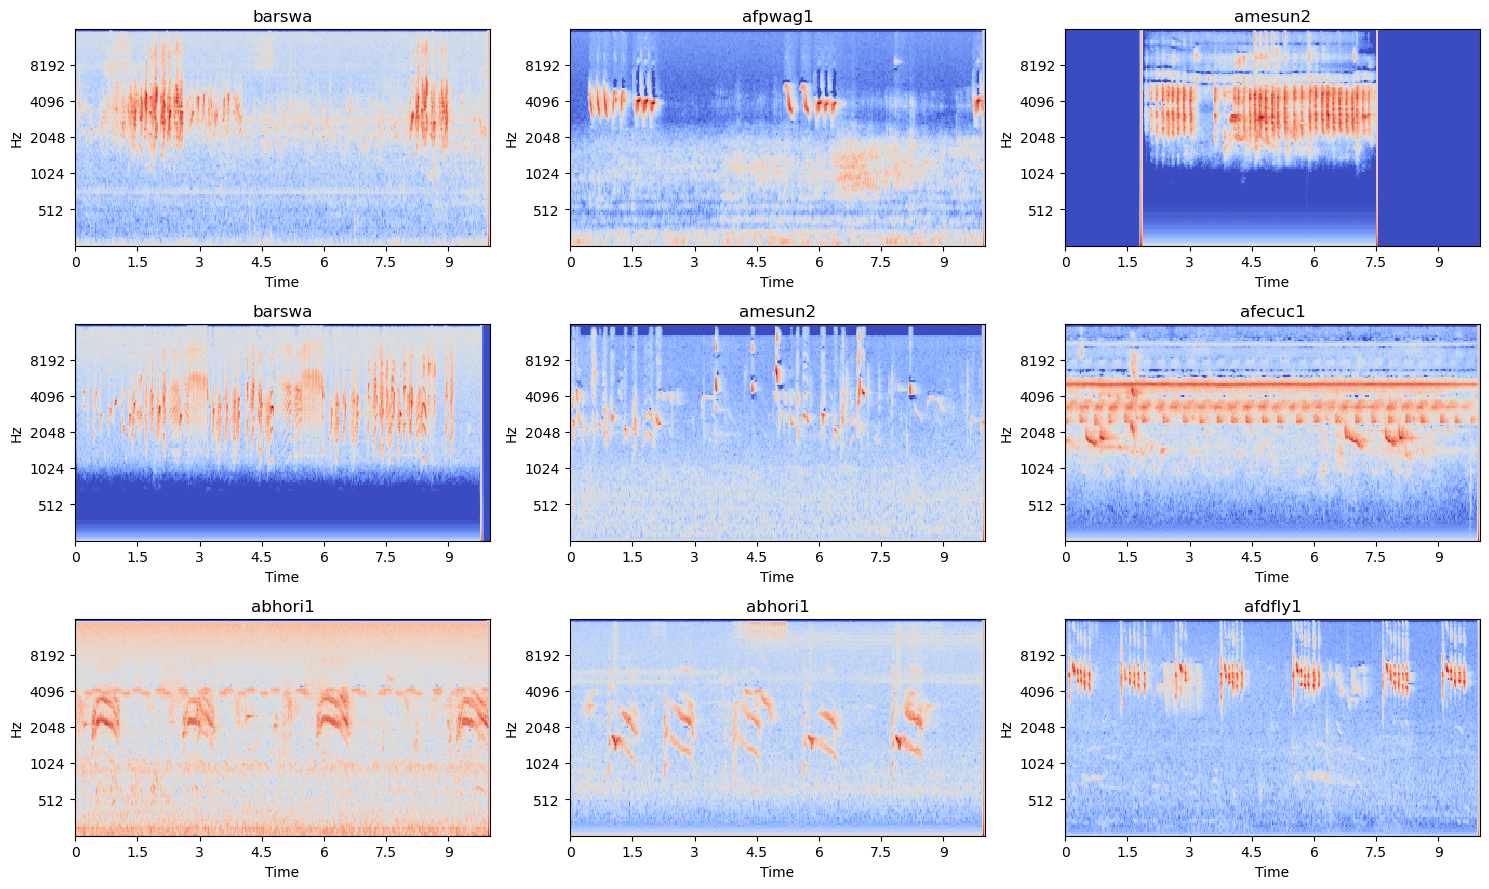

In [34]:
ds = build_dataset(df.filepath.tolist(), df.target.tolist(), augment=False, cache=False)
ds = ds.take(100)
imgs, labels = next(iter(ds))
plot_batch((imgs, labels))

## W/ Augmentation

2023-04-07 02:53:46.939163: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.939355: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.939472: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.940671: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.941061: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.941284: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-07 02:53:46.941426: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed 

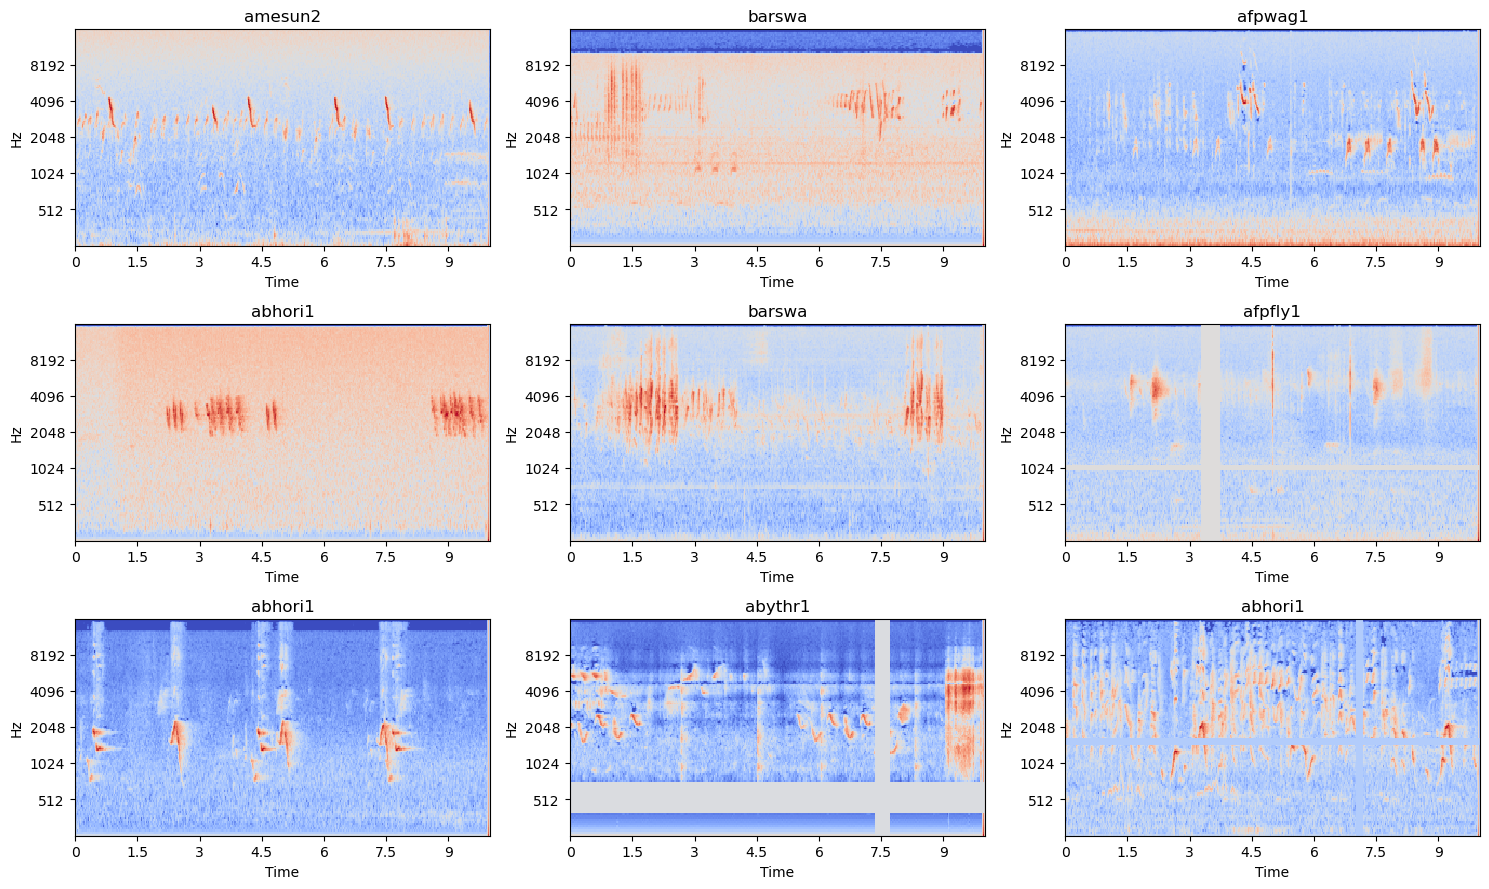

In [35]:
ds = build_dataset(df.filepath.tolist(), df.target.tolist(), augment=True, cache=False)
ds = ds.take(100)
imgs, labels = next(iter(ds))
plot_batch((imgs, labels))

# Loss, Metric & Optmizer 📉
This notebook will use the `Categorical Cross Entropy (CCE)` loss for optimization, accompanied by `AUC (PR Curve)` and `Accuracy` as performance metrics. The model's efficacy will be evaluated using the padded `cmAP` metric, which is a variant of the `macro-averaged average precision` score that is implemented in scikit-learn. You can learn more about `cmAP` metric from [here](https://www.kaggle.com/competitions/birdclef-2023/overview/evaluation). Finally, it will use `Adam` optmizer for training the model.

$$
CCE = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(p_{i,j})
$$

> **Note:** To account for cases where there are zero true positive labels for certain species, and to mitigate the impact of species with very few positive labels, this metric adds five rows of true positives to both the ground_truth and the prediction prior to scoring. This padding technique leads to even the baseline submission having a relatively strong score.

> **Note**: This notebook will use `Precision Recall (PR)` curve for AUC metric instead of typical `ROC` curve.

In [36]:
import sklearn.metrics

def get_metrics():
    # acc = tf.keras.metrics.BinaryAccuracy(name='acc')
    auc = tf.keras.metrics.AUC(curve='PR', name='auc', multi_label=False) # auc on prcision-recall curve
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    return [acc, auc]

def padded_cmap(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

def get_loss():
    if CFG.loss=="CCE":
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing)
    elif CFG.loss=="BCE":
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    else:
        raise ValueError("Loss not found")
    return loss
    
def get_optimizer():
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=CFG.lr)
    else:
        raise ValueError("Optmizer not found")
    return opt

# Modeling 🤖
* The following model employs **Filter Stride Reduction (FSR)**, which reduces the stride of the stem block by a factor of 2. This results in a larger feature map and less information loss.

* As the train data labels are weak, but the test data labels are strong, we trained the model for a longer duration (20 seconds), but it will be inferred on test data with a shorter time duration (5 seconds). To accommodate this requirement, the model's input is defined as (None, None), which allows it to accept **Dynamic Input**.

In [40]:
import efficientnet.tfkeras as efn

def build_model(CFG, compile_model=True):
    """
    Builds and returns a model based on the specified configuration.
    """
    # Set the image input shape
    DIM = (None, None)
    # Load the specified EfficientNet model
    base = getattr(efn, CFG.model_name)(input_shape=(*DIM, 3),
                                        include_top=False,
                                        weights=CFG.pretrain,
                                        fsr=CFG.fsr,
                                        )
    # Create an input layer for the model
    inp = tf.keras.layers.Input(shape=(*DIM, 3))
    # Pass the input through the base model
    out = base(inp)
    # Add a global average pooling layer
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    # Add an optional bottleneck layer
    if CFG.neck_features:
        out = tf.keras.layers.Dense(CFG.num_features, activation='selu')(out)
    # Add a final dense layer for classification
    out = tf.keras.layers.Dense(len(CFG.class_names), activation=CFG.final_act)(out)
    # Create the TensorFlow model with the input and output layers
    model = tf.keras.Model(inputs=inp, outputs=out)
    if compile_model:
        # Set the optimizer
        opt = get_optimizer()
        # Set the loss function
        loss = get_loss()
        # Set the evaluation metrics
        metrics = get_metrics()
        # Compile the model with the specified optimizer, loss function, and metrics
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model

In [41]:
model = build_model(CFG)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 264)               338184    
                                                                 
Total params: 4,387,748
Trainable params: 4,345,732
Non-trainable params: 42,016
_________________________________________________________________


## Check Model O/P

In [42]:
out = model(imgs, training=False)
print(out.shape)

2023-04-07 03:00:13.830246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-04-07 03:00:16.374746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(32, 264)


# LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [44]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=CFG.epochs, plot=False):
    """
    Returns a learning rate scheduler callback for a given batch size, mode, and number of epochs.
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif CFG.scheduler == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif CFG.scheduler == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif CFG.scheduler == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

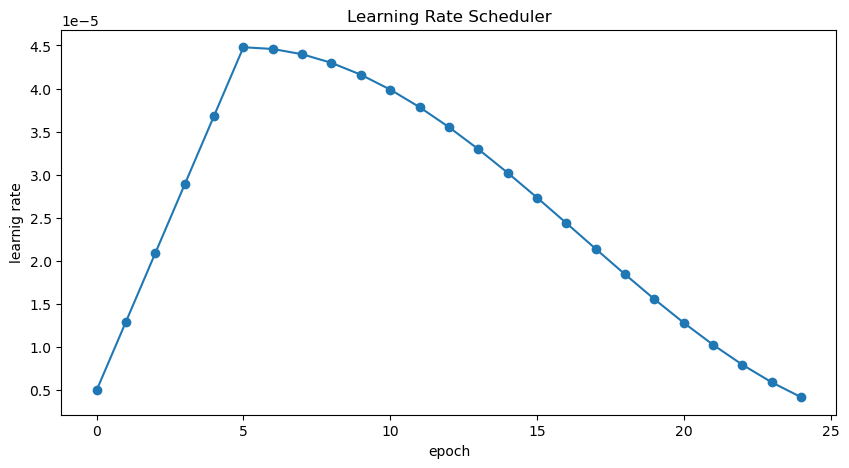

In [45]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# Wandb Logger 🕵️

In [ ]:
import yaml

def wandb_init(fold):
    """
    Initializes the W&B run by creating a config file and initializing a W&B run.
    """
    # Create a dictionary of configuration parameters
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)}) # int is to convert numpy.int -> int
    # Dump the configuration dictionary to a YAML file
    yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
    # Load the configuration dictionary from the YAML file
    config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    # Initialize a W&B run with the given configuration parameters
    run = wandb.init(project="birdclef-2023-public",
                     name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}",
                     config=config,
                     group=CFG.comment,
                     save_code=True,)
    return run

    
def log_wandb(valid_df):
    """Log and save validation results with missclassified examples as audio in W&B"""
    # Query only the rows with miss predictions
    save_df = valid_df.query("miss==True")
    # Map the predicted and target labels to their corresponding names
    save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
    save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
    # Trim the dataframe for debugging purposes
    if CFG.debug:
        save_df = save_df.iloc[:CFG.replicas*CFG.batch_size*CFG.infer_bs]
    # Get the columns to be included in the wandb table
    noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name','pred_name']
    # Retain only the necessary columns
    save_df = save_df.loc[:, noimg_cols]

    data = []
    # Load audio files for each miss prediction
    for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
        filepath = '/kaggle/input/birdclef-2023/train_audio/'+row.filename
        audio, sr = librosa.load(filepath, sr=None)
        # Add the audio file to the data list along with the other relevant information
        data+=[[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
    # Create a wandb table with the audio files and other relevant information
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
    # Log the scores and wandb table to wandb
    wandb.log({'best': scores,
               'table': wandb_table,
               })

# Training 🚅
Our model will be trained on the `train` data and `valid` data will be used to save `checkpoint`.

In [ ]:
oof_pred = []; oof_true = []; oof_val = []; oof_ids = []; oof_folds = [] 

for fold in range(CFG.num_fold):
    # Check if the fold is selected
    if fold not in CFG.selected_folds:
        continue
    
    # Initialize Weights and Biases
    if CFG.wandb:
        run = wandb_init(fold)
        WandbCallback = wandb.keras.WandbCallback(save_model=False)
    
    # Compute batch size and number of samples to drop
    infer_bs = (CFG.batch_size*CFG.infer_bs)
    drop_remainder = CFG.drop_remainder
    
    # Split dataset with cv filter
    if CFG.cv_filter:
        train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
        valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
    else:
        train_df = df.query("fold!=@fold").reset_index(drop=True)
        valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    # Upsample train data
    train_df = upsample_data(train_df, thr=CFG.upsample_thr)

    # Get file paths and labels
    train_paths = train_df.filepath.values; train_labels = train_df.target.values
    valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

    # Shuffle the file paths and labels
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    # For debugging
    if CFG.debug:
        min_samples = CFG.batch_size*CFG.replicas*2
        train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
        valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]

    # Compute the number of training and validation samples
    num_train = len(train_paths); num_valid = len(valid_paths)
        
    # Log the number of training and validation samples if Weights and Biases is being used
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
        
    # Build the training and validation datasets
    cache=True
    train_ds = build_dataset(train_paths, train_labels, 
                             batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=True,
                            drop_remainder=drop_remainder)
    valid_ds = build_dataset(valid_paths, valid_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=False,
                             augment=False, repeat=False, drop_remainder=drop_remainder)
    
    # Print information about the fold and training
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s'%
          (*CFG.img_size, CFG.model_name, CFG.batch_size*CFG.replicas, CFG.scheduler))
    print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))
    
    # Clear the session and build the model
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG)
        
    print('#'*25) 
    
    # Callbacks
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')
    callbacks = [sv, get_lr_callback(CFG.batch_size*CFG.replicas)]
    if CFG.wandb:
        # wandb callback for logging metrics and media
        callbacks.append(WandbCallback)

    # Training
    print('# Training')
    history = model.fit(
        train_ds, 
        epochs=2 if CFG.debug else CFG.epochs, 
        callbacks=callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//CFG.replicas,
        validation_data=valid_ds, 
        verbose=CFG.verbose,
    )
    
    # Load best checkpoint
    print('# Loading best model')
    model.load_weights('fold-%i.h5'%fold)
    
    # Predict on the validation data for oof result
    print('# Infering OOF')
    valid_ds = build_dataset(valid_paths, labels=None, augment=CFG.tta>1, repeat=True, cache=False, 
                             shuffle=False, batch_size=infer_bs*CFG.replicas, 
                             drop_remainder=drop_remainder)
    ct_valid = len(valid_paths); STEPS = CFG.tta * ct_valid/infer_bs/CFG.replicas
    pred = model.predict(valid_ds,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_valid,] 
    pred = np.mean(pred.reshape((CFG.tta,ct_valid,-1)),axis=0)
    oof_pred.append(pred)               

    # Get ids and targets
    oof_true.append(valid_df[CFG.target_col].values[:ct_valid])
    oof_folds.append(np.ones_like(oof_true[-1],dtype='int8')*fold )
    oof_ids.append(valid_paths)
   
    # Save valid data prediction
    y_true = oof_true[-1].reshape(-1).astype('float32')
    y_pred = oof_pred[-1].argmax(axis=-1)
    valid_df.loc[:num_valid - 1, 'pred'] = y_pred
    valid_df.loc[:num_valid - 1, 'miss'] = y_true != y_pred
    valid_df.loc[:num_valid - 1, CFG.class_names] = oof_pred[-1].tolist()
    valid_df.to_csv(f'fold_{fold:02d}.csv',index=False)
    
    # Log the metrics
    scores = {}
    cmAP = padded_cmap(tf.keras.utils.to_categorical(y_true), oof_pred[-1])
    best_epoch = np.argmax(history.history['val_'+CFG.monitor], axis=-1) + 1
    best_score = history.history['val_'+CFG.monitor][best_epoch - 1]
    scores.update({'auc': best_score,
                   'epoch': best_epoch,
                   'cmAP': cmAP,})
    oof_val.append(best_score)
    print('\n>>> FOLD %i OOF AUC = %.3f | Padded_cmAP = %.3f' % (fold, oof_val[-1], cmAP))
    
    # Show training plot
    if CFG.training_plot:
        plot_history(history)
        
    # Log metrics, media to wandb
    if CFG.wandb:
        print('# WandB')
        log_wandb(valid_df)
        wandb.run.finish()
        display(ipd.IFrame(run.url, width=1080, height=720))

## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/birdclef-2023-public) to check training log in **WandB** dashboard.

<img src="https://i.postimg.cc/Pxg61FhY/wandb-dashboard-birdclef23.png">

# Performance 🎭
In the following section we'll look into our overall score of `cmAP`

In [ ]:
def get_id(row):
    row['filename'] = row['filepath'].split('/',5)[-1]
    return row

In [ ]:
# OOF Data
y_pred = np.concatenate(oof_pred); y_true = np.concatenate(oof_true);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)

# Overall cmAP
cmAP = padded_cmap(tf.keras.utils.to_categorical(y_true), y_pred)

# Overall AUC in PR curve
m = tf.keras.metrics.AUC(curve='PR')
m.update_state(tf.keras.utils.to_categorical(y_true), y_pred)
auc = m.result().numpy()

print('>>> Overall cmAP: ', cmAP)
print('>>> Overall AUC(PR): ', auc)

## Save OOF

In [ ]:
# Save OOF data to disk
columns = ['filepath', 'fold', 'true', 'pred', *CFG.class_names]
df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds, y_true,
                                      np.argmax(y_pred,axis=1)[:,None], y_pred], axis=1), columns=columns)
df_oof['class_name'] = df_oof.true.map(CFG.label2name)
df_oof['miss'] = df_oof.true!=df_oof.pred
tqdm.pandas(desc='id ')
df_oof = df_oof.progress_apply(get_id,axis=1)
df_oof.to_csv('oof.csv',index=False)
display(df_oof.head(2))

## Missed Cases

In [ ]:
print('Miss Total:')
display(df_oof.query("miss==True").shape[0])

print()
print('Miss Distribution Top10:')
display(df_oof.query("miss==True").class_name.value_counts()[:10])

# Reference ✍️
* [Fake Speech Detection: Conformer [TF]](https://www.kaggle.com/code/awsaf49/fake-speech-detection-conformer-tf/) by @awsaf49
* [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/code/xhlulu/ranzcr-efficientnet-tpu-training) by @xhlulu
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte

# Remove Files ✂️

In [ ]:
import shutil
try:
    !rm -rf ./wandb
except:
    pass